In [192]:
### SETUP
import torch
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import csv
from matplotlib.colors import Normalize
import torch.nn as nn
import torch.nn.functional as F

In [193]:
### FUNCTIONS FOR PLOTTING HINTON ACCURACIES

def load_accuracies_from_csv(filepath):
    """Load Hinton Accuracies from a CSV"""
    data = []
    with open(filepath, mode='r', newline='') as file:
        reader = csv.DictReader(file)
        for row in reader:
            hidden_dim = int(row['hidden_dim'])
            temp = row.get('temperature', 'N/A')
            temperature = None if temp == 'N/A' else float(temp)
            accuracy = float(row['accuracy'])
            data.append({
                'Hidden Dimension': hidden_dim,
                'Temperature': temperature,
                'Accuracy': accuracy
            })
    return data


<Axes: title={'center': 'Neurons Remaining vs Datapoints on MNIST Even Digits'}, xlabel='Neurons Remaining', ylabel='Datapoints'>

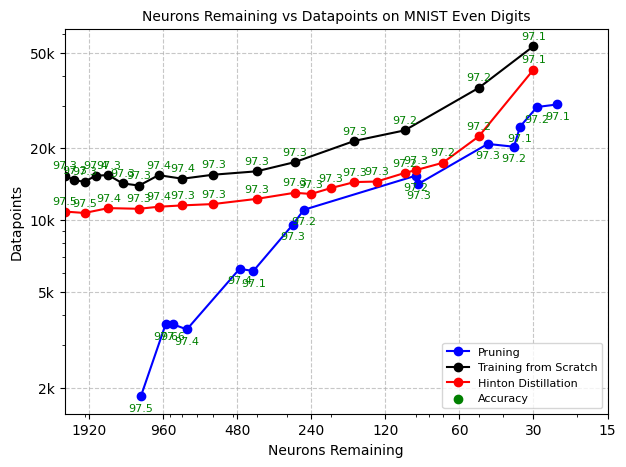

In [198]:
### EQUIVALENT METHODS FOR VISUALIZING PRUNING DATA

def load_accuracies_by_neurons(filepath):
    """Load data from a CSV file with columns Active Neurons, Beta, Accuracy, etc."""
    data = []
    with open(filepath, mode='r', newline='') as file:
        reader = csv.DictReader(file)
        for row in reader:
            active_neurons = int(float(row['Active Neurons']))
            beta = float(row['Beta'])
            accuracy = float(row['Accuracy'])
            epoch = float(row['Epoch'])  # Changed to float to handle decimal values
            datapoints = float(row['Datapoints'])  # Changed to float to handle decimal values
            pruning_penalty = row.get('Pruning Penalty', 'N/A')  # Added to handle the new column
            
            data.append({
                'Active Neurons': active_neurons,
                'Beta': beta,
                'Accuracy': accuracy,
                'Epoch': epoch,
                'Datapoints': datapoints,
                'Pruning Penalty': pruning_penalty
            })
    return data

def plot_datapoints_vs_neurons_with_accuracy_labels(data, csv_filepath, second_filepath, ax=None):
    """Plot Datapoints versus Neurons Remaining, with points labeled by Accuracy."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 5))
    
    # Sort the pruning data to ensure that the points are connected with one continuous trendline.
    sorted_data = sorted(data, key=lambda d: d['Active Neurons'])
    pruning_neurons_remaining = [d['Active Neurons'] for d in sorted_data]
    pruning_datapoints = [d['Datapoints'] for d in sorted_data]
    pruning_accuracies = [d['Accuracy'] for d in sorted_data]
    
    # Plot the pruning data using one continuous trendline.
    ax.plot(pruning_neurons_remaining, pruning_datapoints, 'o-', label='Pruning', color='blue')
    for x, y, acc in zip(pruning_neurons_remaining, pruning_datapoints, pruning_accuracies):
        ax.annotate(f'{acc:.1f}', (x, y), textcoords="offset points", xytext=(0, -5), ha='center', va='top', color='green', fontsize=8)
    
    # Load and plot data from the first CSV (training from scratch)
    with open(csv_filepath, mode='r') as file:
        reader = csv.DictReader(file)
        rows = list(reader)
        csv_datapoints = []
        csv_neurons_remaining = []
        csv_accuracies = []
        for row in rows:
            csv_datapoints.append(float(row['Datapoints']))
            csv_neurons_remaining.append(int(row['Neurons Remaining']))
            csv_accuracies.append(float(row['Accuracy']))
    
    ax.plot(csv_neurons_remaining, csv_datapoints, 'o-', label='Training from Scratch', color='black')
    for x, y, acc in zip(csv_neurons_remaining, csv_datapoints, csv_accuracies):
        ax.annotate(f'{acc:.1f}', (x, y), textcoords="offset points", xytext=(0, 5), ha='center', color='green', fontsize=8)
    
    # Load and plot data from the second CSV (Hinton Distillation, T=20)
    with open(second_filepath, mode='r') as file:
        reader = csv.DictReader(file)
        rows = list(reader)
        csv_datapoints = []
        csv_neurons_remaining = []
        csv_accuracies = []
        for row in rows:
            if 'Datapoints' in row:
                csv_datapoints.append(float(row['Datapoints']))
            csv_neurons_remaining.append(int(row['Neurons Remaining']))
            csv_accuracies.append(float(row['Accuracy']))

    ax.plot(csv_neurons_remaining, csv_datapoints, 'o-', label='Hinton Distillation', color='red')
    for x, y, acc in zip(csv_neurons_remaining, csv_datapoints, csv_accuracies):
        ax.annotate(f'{acc:.1f}', (x, y), textcoords="offset points", xytext=(0, 5), ha='center', color='green', fontsize=8)

    # Axis labels and scales (note the axes are flipped)
    ax.set_xlabel('Neurons Remaining')
    ax.set_ylabel('Datapoints')
    ax.set_xscale('log')
    ax.set_yscale('log')
    min_x = 15  # Force the minimum on the x-axis to be 15
    max_x = max([max(pruning_neurons_remaining), max(csv_neurons_remaining)])
    ax.set_xlim(min_x, max(max_x, 1100))
    
    import matplotlib.ticker as ticker
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.xaxis.set_major_locator(ticker.FixedLocator([15, 30, 60, 120, 240, 480, 960, 1920]))
    ax.xaxis.get_major_formatter().set_scientific(False)
    ax.xaxis.get_major_formatter().set_useOffset(False)
    
    y_values = [1000, 2000, 5000, 10000, 20000, 50000, 100000, 200000, 500000, 1000000]
    ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.yaxis.set_major_locator(ticker.FixedLocator(y_values))
    ax.yaxis.get_major_formatter().set_scientific(False)
    
    def y_fmt(x, pos):
        if x >= 1000000:
            return f'{x/1000000:.0f}M'
        elif x >= 1000:
            return f'{x/1000:.0f}k'
        else:
            return f'{x:.0f}'
    
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(y_fmt))
    
    ax.set_title('Neurons Remaining vs Datapoints on MNIST Even Digits', fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.scatter([], [], color='green', label='Accuracy')
    ax.legend(loc='lower right', fontsize=8)
    ax.invert_xaxis()
    
    return ax

# Note that Hinton and training from scratch could not consistently get to 20 neurons, whereas pruning could
data = load_accuracies_by_neurons("/afs/csail.mit.edu/u/a/asher/narrow/asher/data/pruning.csv")
trained_from_scratch =  "/afs/csail.mit.edu/u/a/asher/narrow/asher/data/training_accuracies_updated.csv"
hinton_csv = "/afs/csail.mit.edu/u/a/asher/narrow/asher/data/student_training_accuracies.csv"
plot_datapoints_vs_neurons_with_accuracy_labels(data, trained_from_scratch, hinton_csv)
# plot_neurons_vs_accuracy(data)
# plot_epochs_vs_accuracy(data)
# plot_epochs_vs_neurons(data)
# plot_total_datapoints_vs_neurons(data)

# 5.5 is total length of width of page

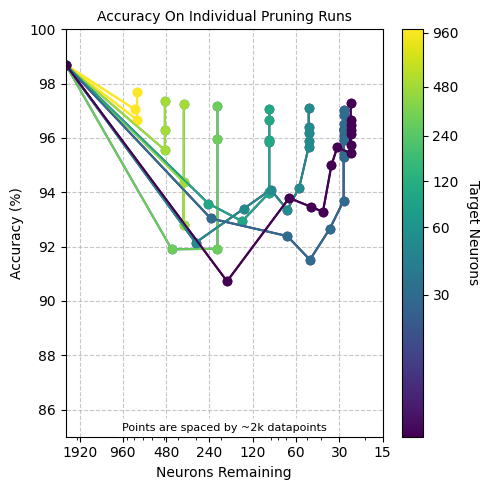

<Axes: title={'center': 'Accuracy On Individual Pruning Runs'}, xlabel='Neurons Remaining', ylabel='Accuracy (%)'>

In [209]:
def plot_pruning_accuracy_vs_neurons(json_filepath, ax=None):
    """Plot each pruning run's accuracy vs neurons remaining with viridis colormap"""
    import matplotlib.pyplot as plt
    import matplotlib.ticker as ticker
    import matplotlib.cm as cm
    import numpy as np
    import json
    
    # Create figure if no axes is provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 5))
        standalone = True
    else:
        standalone = False
    
    # Load the pruning checkpoints data
    pruning_runs = load_pruning_checkpoints_from_json(json_filepath)
    
    # Sort runs by target neurons (highest to lowest)
    pruning_runs = sorted(pruning_runs, key=lambda run: run["metadata"]["target_neurons"], reverse=True)
    
    # Get target neurons for color mapping
    target_neurons_list = [run["metadata"]["target_neurons"] for run in pruning_runs]
    
    # Create a normalized colormap based on target neurons
    norm = plt.Normalize(min(target_neurons_list), max(target_neurons_list))
    cmap = cm.viridis
    
    # Store line objects for legend
    lines = []
    
    # Plot each run as a separate line
    for i, run in enumerate(pruning_runs):
        target_neurons = run["metadata"]["target_neurons"]
        final_neurons = run["metadata"]["final_active_neurons"]
        checkpoints = run["checkpoints"]
        
        # Sort checkpoints by active_neurons to ensure proper line connectivity
        checkpoints = sorted(checkpoints, key=lambda x: x["active_neurons"], reverse=True)
        
        # Extract data for plotting
        active_neurons = [checkpoint["active_neurons"] for checkpoint in checkpoints]
        accuracies = [checkpoint["accuracy"] for checkpoint in checkpoints]
        datapoints = [checkpoint["datapoints"] for checkpoint in checkpoints]
        
        # Add the starting point at (2400, 98.7)
        active_neurons.insert(0, 2400)
        accuracies.insert(0, 98.7)
        datapoints.insert(0, 100)
        
        # Get color from colormap based on target neurons
        color = cmap(norm(target_neurons))
        
        # Plot the line for this run
        line, = ax.plot(active_neurons, accuracies, 'o-', color=color)
        lines.append(line)
    
    
    # Axis labels and scales
    ax.set_xlabel('Neurons Remaining')
    ax.set_ylabel('Accuracy (%)')
    
    # Configure axes
    ax.set_xscale('log')  # Keep x-axis logarithmic
    
    # Set axis limits
    min_x = 15  # Force the minimum on the x-axis to be 15
    all_neurons = [checkpoint["active_neurons"] for run in pruning_runs for checkpoint in run["checkpoints"]]
    max_x = max(max(all_neurons), 2400)  # Ensure x limit includes 2400
    ax.set_xlim(min_x, max_x)
    
    # Set y-axis limits for accuracy
    min_accuracy = min([min([checkpoint["accuracy"] for checkpoint in run["checkpoints"]]) for run in pruning_runs])
    ax.set_ylim(85, 100)  # Give some padding below the minimum accuracy
    
    # Configure x-axis ticks
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.xaxis.set_major_locator(ticker.FixedLocator([15, 30, 60, 120, 240, 480, 960, 1920]))
    ax.xaxis.get_major_formatter().set_scientific(False)
    ax.xaxis.get_major_formatter().set_useOffset(False)
    
    # Add title and grid
    ax.set_title('Accuracy On Individual Pruning Runs', fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Create a normalized color map based on target neurons
    from matplotlib.colors import PowerNorm
    # Use PowerNorm with gamma < 1 to emphasize differences in lower values
    norm = PowerNorm(gamma=0.2, vmin=min(target_neurons_list), vmax=max(target_neurons_list))
    cmap = cm.viridis

    # Plot each run as a separate line
    for i, run in enumerate(pruning_runs):
        target_neurons = run["metadata"]["target_neurons"]
        final_neurons = run["metadata"]["final_active_neurons"]
        checkpoints = run["checkpoints"]
        
        # Sort checkpoints by active_neurons to ensure proper line connectivity
        checkpoints = sorted(checkpoints, key=lambda x: x["active_neurons"], reverse=True)
        
        # Extract data for plotting
        active_neurons = [checkpoint["active_neurons"] for checkpoint in checkpoints]
        accuracies = [checkpoint["accuracy"] for checkpoint in checkpoints]
        datapoints = [checkpoint["datapoints"] for checkpoint in checkpoints]
        
        # Add the starting point at (2400, 98.7)
        active_neurons.insert(0, 2400)
        accuracies.insert(0, 98.7)
        datapoints.insert(0, 100)
        
        # Get color from colormap based on target neurons - make sure to use the same norm
        color = cmap(norm(target_neurons))
        
        # Plot the line for this run
        line, = ax.plot(active_neurons, accuracies, 'o-', color=color)
        lines.append(line)
    # Add colorbar for target neurons
    if standalone:
        cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
        cbar.set_label('Target Neurons', rotation=270, labelpad=15)
    else:
        # For the combined plot, we need to create the colorbar differently
        from mpl_toolkits.axes_grid1 import make_axes_locatable
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax)
        cbar.set_label('Target Neurons', rotation=270, labelpad=15, fontsize=8)

    # Set custom ticks directly on the values, not the normalized positions
    tick_values = [30, 60, 120, 240, 480, 960]
    cbar.set_ticks(tick_values)
    cbar.set_ticklabels([str(x) for x in tick_values])

    # Invert x-axis to show decreasing neurons
    ax.invert_xaxis()
    
    ax.text(
        0.5, 0.01,  # Position in axis coordinates (center, bottom)
        "Points are spaced by ~2k datapoints",
        horizontalalignment='center', 
        verticalalignment='bottom',
        transform=ax.transAxes,  # Use axis coordinates
        fontsize=8,
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=3)
    )
    if standalone:
        plt.tight_layout()
        plt.show()

    return ax
    
# Example usage
plot_pruning_accuracy_vs_neurons("data/pruning_checkpoints.json")

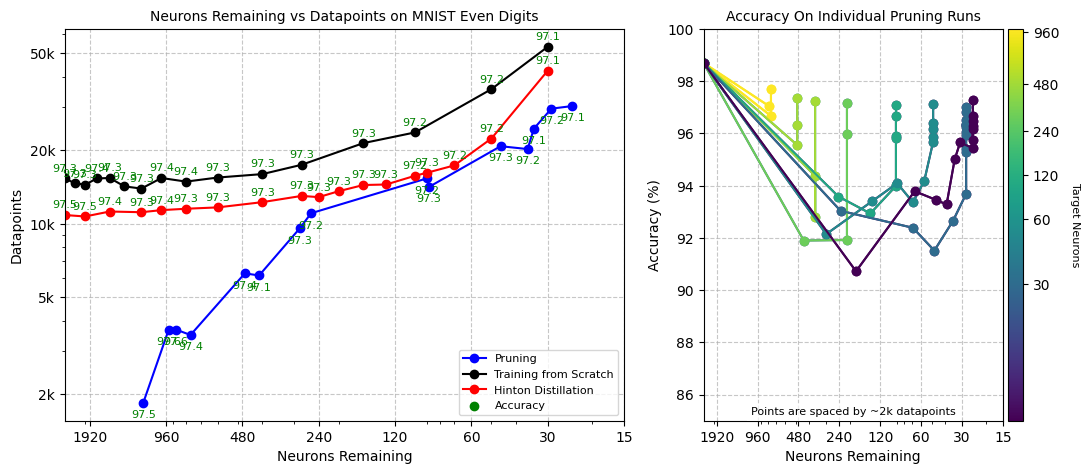

In [210]:
def combined_comparison_plot():
    """Combine both plots side by side in one figure"""
    import matplotlib.pyplot as plt
    
    # Create figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5), gridspec_kw={'width_ratios': [3.5, 2]})
    
    # Generate the left subplot - Neurons vs Datapoints with all methods
    data = load_accuracies_by_neurons("data/pruning.csv")
    trained_from_scratch = "data/training_accuracies_updated.csv"
    hinton_csv = "data/student_training_accuracies.csv"
    plot_datapoints_vs_neurons_with_accuracy_labels(data, trained_from_scratch, hinton_csv, ax=ax1)
    
    # Generate the right subplot - Neurons vs Accuracy for individual pruning runs
    plot_pruning_accuracy_vs_neurons("data/pruning_checkpoints.json", ax=ax2)
        
    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # Make room for the suptitle
    
    plt.show()

# Example usage
combined_comparison_plot()

In [191]:
### OTHER MISCELLANEOUS VISUALIZATIONS

import torch
import torch.nn as nn
class StudentNet(nn.Module):
    def __init__(self, hidden_dim):
        super(StudentNet, self).__init__()
        self.fc1 = nn.Linear(28 * 28, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
class Net(nn.Module):
    def __init__(self, input_dim=28 * 28, hidden_dims=[1200, 1200], output_dim=10):
        super(Net, self).__init__()
        self.fc_layers = nn.ModuleList()
        previous_dim = input_dim
        for h_dim in hidden_dims:
            self.fc_layers.append(nn.Linear(previous_dim, h_dim))
            previous_dim = h_dim
        self.output_layer = nn.Linear(previous_dim, output_dim)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        for fc in self.fc_layers:
            x = F.relu(fc(x))
        x = self.output_layer(x)
        return x

In [46]:
import torch
import matplotlib.pyplot as plt

def plot_weight_distributions(model_path):

    # Define the model class as per pruning.py
    class Net(nn.Module):
        def __init__(self, input_dim=28 * 28, hidden_dims=[1200, 1200], output_dim=10):
            super(Net, self).__init__()
            self.fc_layers = nn.ModuleList()
            previous_dim = input_dim
            for h_dim in hidden_dims:
                self.fc_layers.append(nn.Linear(previous_dim, h_dim))
                previous_dim = h_dim
            self.output_layer = nn.Linear(previous_dim, output_dim)

        def forward(self, x):
            x = x.view(-1, 28 * 28)
            for fc in self.fc_layers:
                x = F.relu(fc(x))
            x = self.output_layer(x)
            return x

    # Initialize the model with the correct architecture
    model = Net(hidden_dims=[200, 200])

    # Load the state_dict into the model
    state_dict = torch.load(model_path)
    model.load_state_dict(state_dict)

    """Plots histograms of the weight distributions for each layer in the model."""
    for i, layer in enumerate(model.fc_layers):
        weights = layer.weight.data.cpu().numpy().flatten()
        plt.figure(figsize=(8, 4))
        plt.hist(weights, bins=50, alpha=0.7, color='blue')
        plt.title(f'Layer {i} Weight Distribution')
        plt.xlabel('Weight Value')
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.show()

    # Plot for the output layer
    output_weights = model.output_layer.weight.data.cpu().numpy().flatten()
    plt.figure(figsize=(8, 4))
    plt.hist(output_weights, bins=50, alpha=0.7, color='green')
    plt.title('Output Layer Weight Distribution')
    plt.xlabel('Weight Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()


/tmp/ipykernel_2357112/1895955806.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path)


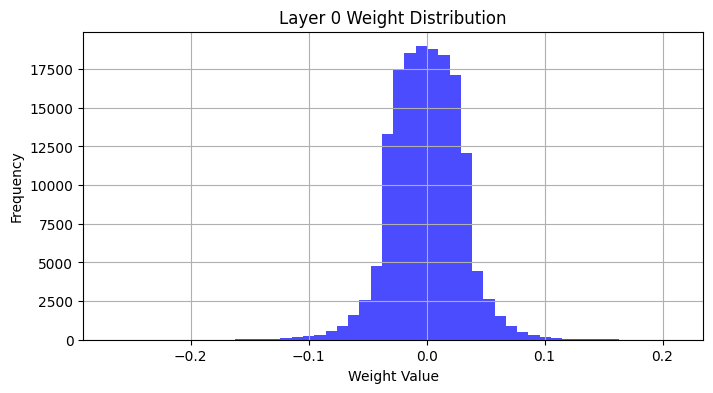

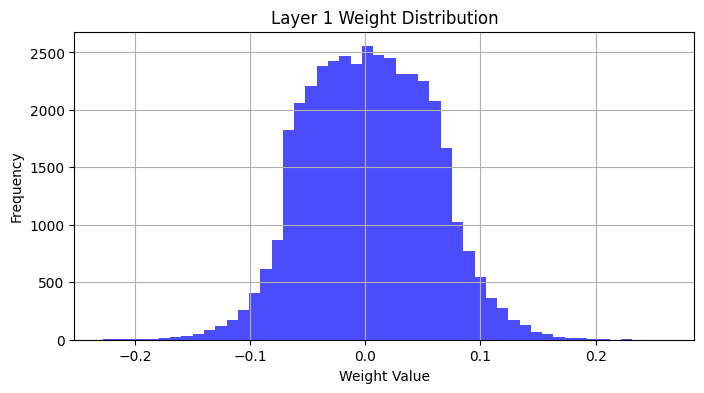

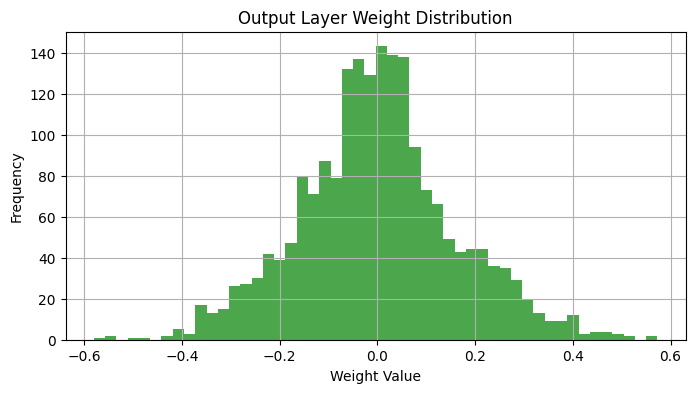

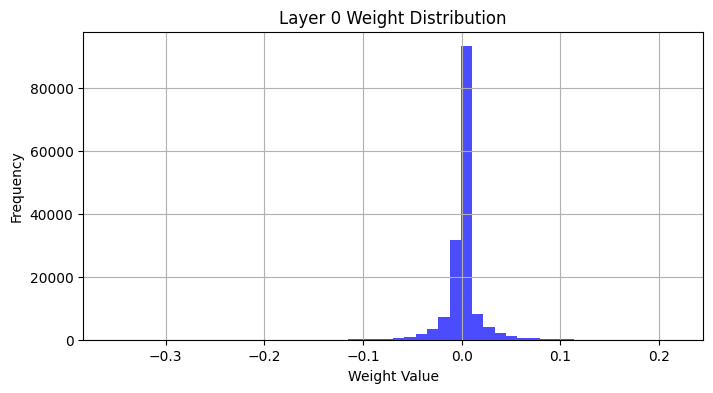

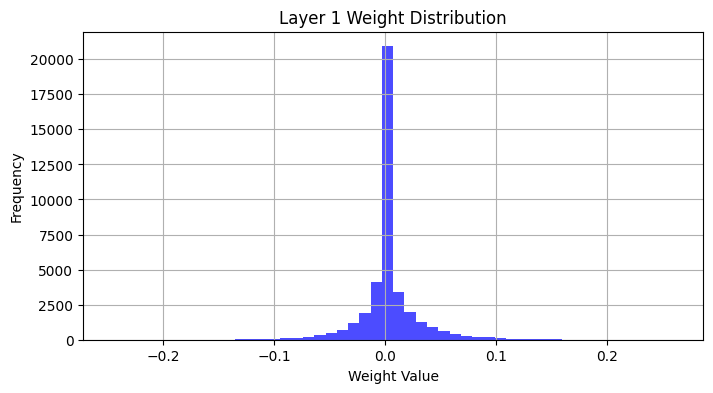

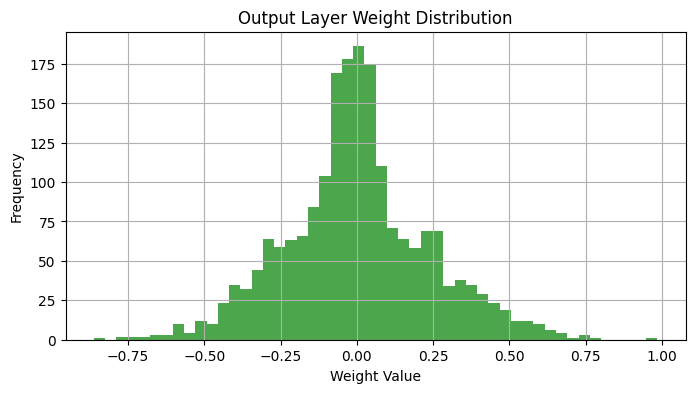

In [47]:
plot_weight_distributions('models/teacher_hidden200.pth')
plot_weight_distributions("models/student_hidden200_beta0.001.pth")